# Week 1: Introduction to Jupyter Notebooks
### MAQ - 32806, Chiel van Heerwaarden & Imme Benedict, 2016
This is the first tutorial. In this tutorial, you will get used to the Jupyter Notebooks, and their work flow. In Jupyter notebooks you can write either text in Markdown format (including mathematics using LaTeX) or code in Python format. In this course, you will work on assignments that you are going to work out in your own notebook.
___

### SOME ESSENTIAL TIPS BEFORE STARTING!
* Make a copy of the notebook via the `File` menu. By doing so, you always have the original file to revert to.
* Save your work often.
* In case of weird behavior, try to restart the notebook via the `Kernel` menu.
* Play around, the best way to find out how things work is to try them out!
* Use the internet for help on `numpy`, `matplotlib`, `Basemap` or `LaTeX` if you want to try something out.
* With `Shift+Enter` you can move down while executing cells.
* You can complete commands by pressing `Tab`.
___

### Setting up a Python Basemap and read out 3D fields
We start the tutorial by loading the required Python packages and setting the figure properties.

In [1]:
import numpy as np              # Numpy is the package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of our meteorological data.
import matplotlib.pyplot as pl  # Matplotlib is a scientific plotting package.

from mpl_toolkits.basemap import Basemap # Import the map plotting interface.

# The statement below enforces the plots to be put inline.
%pylab inline
pl.rcParams.update({'font.size': 12})          # Set the font size of the plots to 12pt.
pl.rcParams.update({'figure.figsize': [13,6]}) # Set the standard figure size.

Populating the interactive namespace from numpy and matplotlib


___
With the code below, you initialize the world map with the desired coordinates.

In [2]:
lon_start = -150.
lon_end   =   50.
lat_start =   20.
lat_end   =   70.
m = Basemap(llcrnrlon=lon_start,
            llcrnrlat=lat_start,
            urcrnrlon=lon_end,
            urcrnrlat=lat_end,
            projection='mill', resolution='l')

___
Now, you load the data and read out the desired variables from a NetCDF file from the ECMWF ERA-Interim data archive. You are loading a file with data from October 1st, 2015.

In [3]:
nc_file = nc.Dataset("data/era_data.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]
p = nc_file.variables["level"][:]*100.  # Conversion of pressure to Pa.

t = 0 # We only load the first time index from the data.
time = nc_file.variables["time"][0]

# With the code below, we roll the map, to get the 0 meridian,
# rather than the Pacific in the middle.
nroll = lon.size//2
lon = np.roll(lon, nroll)
lon = np.where(lon>=180., lon-360., lon)

# We load 3D fields of the two horizontal wind components, the geopotential and the temperature.
u     = np.roll(nc_file.variables["u"][t,:,:,:], nroll, -1)
v     = np.roll(nc_file.variables["v"][t,:,:,:], nroll, -1)
omega = np.roll(nc_file.variables["w"][t,:,:,:], nroll, -1)
Phi   = np.roll(nc_file.variables["z"][t,:,:,:], nroll, -1)
T     = np.roll(nc_file.variables["t"][t,:,:,:], nroll, -1)

nc_file.close() # The file access is closed as no further data is needed now.

# We create two-dimensional grids for lons and lats in degrees and radians. These arrays
# are used for plotting and computation.
lons, lats = m(*np.meshgrid(lon, lat))
lonrad, latrad = np.meshgrid(np.pi/180.*lon, np.pi/180.*lat)

This is it. With the actions below, you have done everything to be able to work with ECMWF ERA-Interim weather data.
___

### Working with numpy
Before plotting the data, we have a quick look at the shape of the loaded data. Our 3D fields have three dimensions: `height`, `lat` and `lon` from which we can select the desired fields. Pressure is the height coordinate of our data. Below we show some simple examples.

In [4]:
print(Phi.shape)     # We have 37 height levels, 241 latitudes and 480 longitudes.
print(p[0])        # Our lowest pressure level is 1000 hPa.
print(p[6])        # At level 6 we find 850 hPa.
Phi_850 = Phi[6,:,:]   # We create a new variable that contains only the geopotential height at 850 hPa.
print(Phi_850.shape) # The new data has only two dimensions, lat and lon.

# We can also write formatted output to the screen.
print("The standard deviation is {0}".format(np.std(Phi_850))) # We can format the output.
print("The mean, min and max are {0}, {1}, {2}".format(np.mean(Phi_850), np.min(Phi_850), np.max(Phi_850)))

(37, 241, 480)
100000.0
85000.0
(241, 480)
The standard deviation is 1587.8661158560112
The mean, min and max are 13561.70812564149, 9429.24728703004, 16474.802276500996


___
### Plotting data
We are now going to plot the temperature $T$ and geopotential $\Phi$ at 500 hPa. Note that our units are SI.

/usr/local/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


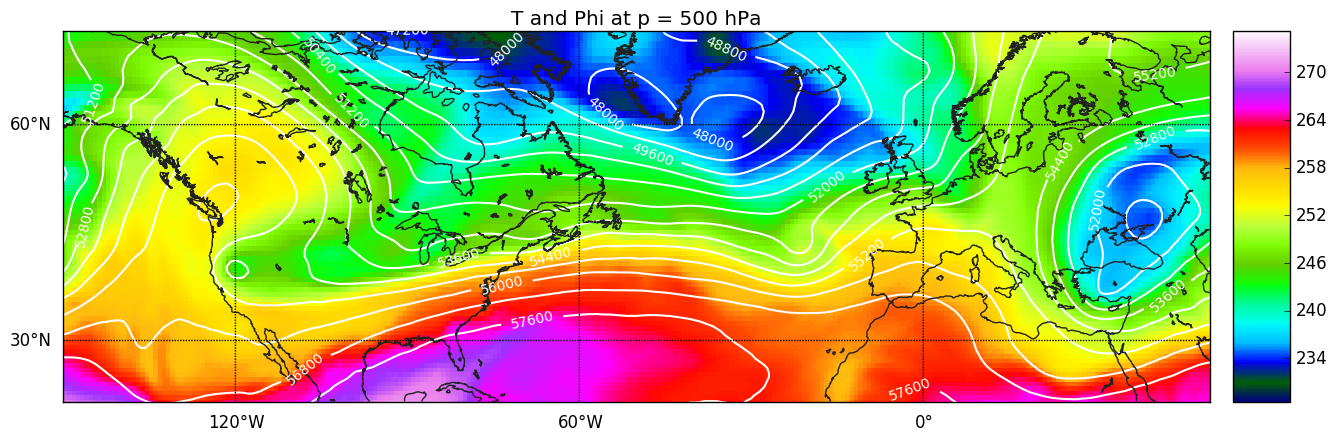

In [5]:
p_plot = 50000.            # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

m.pcolormesh(lons, lats, T[n,:,:], cmap=pl.cm.gist_ncar)        # We plot a colormesh using the gist_ncar colormap.
m.colorbar()                                                    # We add a colorbar to show the values of temperature.
cz = m.contour(lons, lats, Phi[n,:,:], 15, colors='w', linewidths=1.5) # We plot the geopotential in contours.
pl.clabel(cz, fmt='%1.0f', fontsize=10.) # We add labels to the contour lines.
m.drawcoastlines(color='#222222') # We add coastlines.
# Draw parallels.
parallels = np.arange(0.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0])
# Draw meridians.
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('T and Phi at p = {0:.0f} hPa'.format(p[n]/100.)); # We add a title to the plot. 
pl.tight_layout() # With this function we make the figure fit as good as possible.

___
It is also possible to make simple line plots. Below we plot the temperature profile in Wageningen.

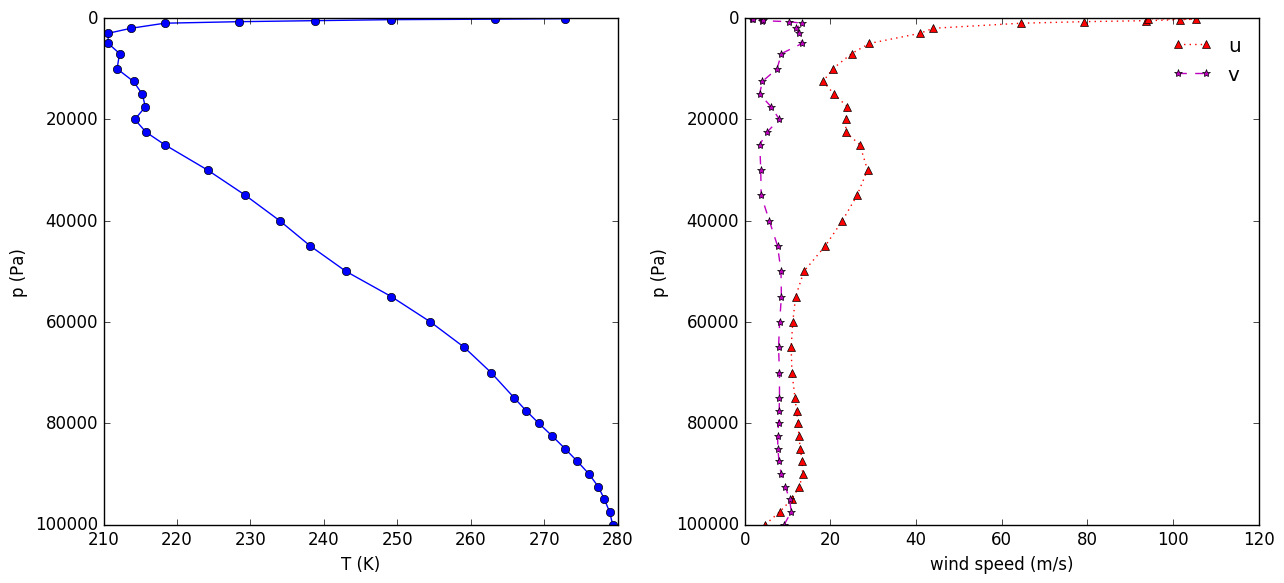

In [6]:
lat_plot = 51.97
lon_plot = 5.67
i_lon = abs(lon - lon_plot).argmin()
j_lat = abs(lat - lat_plot).argmin()

pl.subplot(121)
pl.plot(T[:,j_lat,i_lon], p, 'bo-')
pl.xlabel('T (K)')
pl.ylabel('p (Pa)')
pl.gca().invert_yaxis()

pl.subplot(122)
pl.plot(u[:,j_lat,i_lon], p, 'r^:' , label='u')
pl.plot(v[:,j_lat,i_lon], p, 'm*--', label='v')
pl.xlabel('wind speed (m/s)')
pl.ylabel('p (Pa)')
pl.legend(loc=0, frameon=False)
pl.gca().invert_yaxis()
pl.tight_layout()

___
### Manipulating data
In Python, the underlying language of the notebooks, it is very easy to do manipulations on the data. Below, we calculate the 3D field of total wind speed and plot it. Again, we plot the data on the previously defined index of the 500 hPa level `n`. We calculate the total wind speed $U$ as
$$ U = \sqrt{u^2 + v^2} $$

The equation above has been rendered using $\LaTeX$, which is very useful for typesetting equations.

/usr/local/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


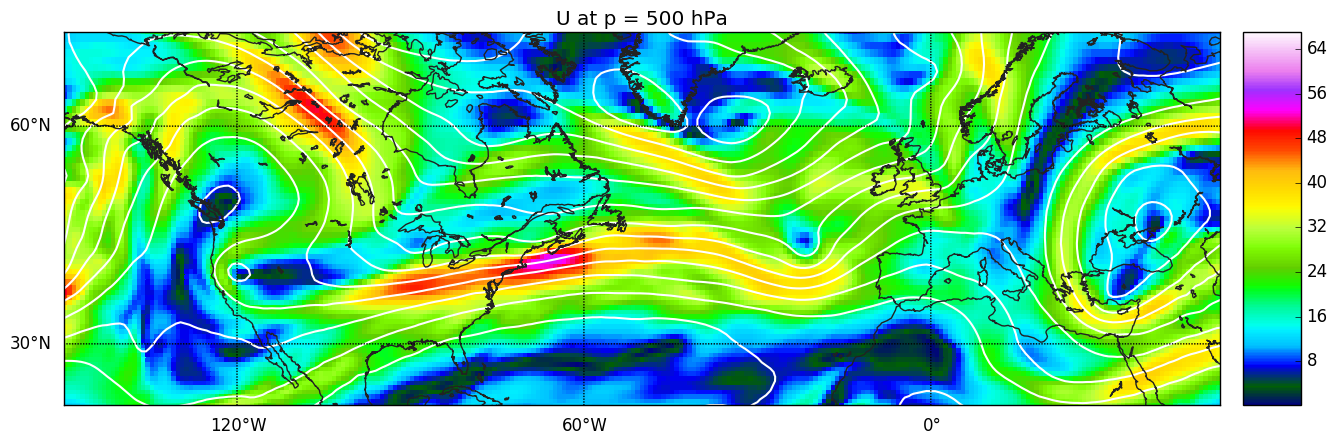

In [7]:
U = (u**2 + v**2)**.5

m.pcolormesh(lons, lats, U[n,:,:], cmap=pl.cm.gist_ncar)
m.colorbar()
m.contour(lons, lats, Phi[n,:,:], 15, colors='w', linewidths=1.5)
m.drawcoastlines(color='#222222')
# draw parallels.
parallels = np.arange(0.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('U at p = {0:.0f} hPa'.format(p[n]/100.));
pl.tight_layout()

___
The `numpy` package provides function for averaging arrays over a chosen axis. Below we calculate and plot the vertical profile of zonal mean temperature.

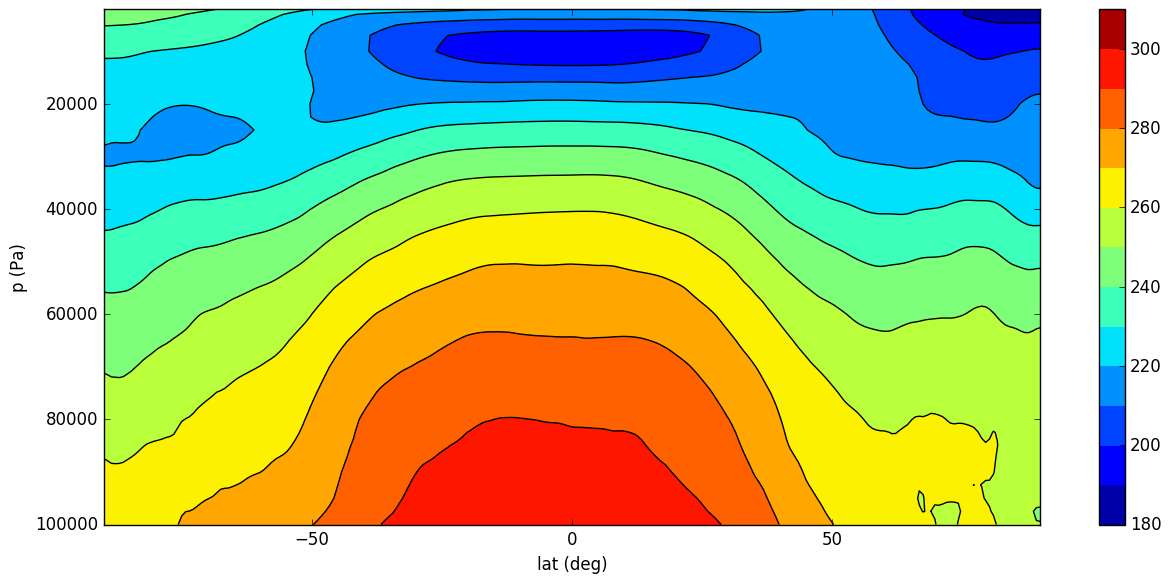

In [8]:
T_zonal_mean = np.mean(T, axis=2) # Compute the mean over the longitude axis.

T_contours = np.arange(180, 320, 10)                       # Define the contour levels.
pl.contourf(lat, p, T_zonal_mean, T_contours)              # Plot a colored contour plot
pl.colorbar()                                              # Plot a colorbar.
pl.contour (lat, p, T_zonal_mean, T_contours, colors='k')  # Plot line contours.
pl.gca().invert_yaxis()                                    # Reverse the y-axis.
pl.xlabel('lat (deg)')
pl.ylabel('p (Pa)')
pl.xlim(-90, 90)
pl.ylim(1e5, 2e3)
pl.tight_layout()

#### A WORD OF WARNING
The `axis=` specification can be quite confusing. The field `T[:,:,:]` has three dimensions. The first (`axis=0`) is the height in pressure levels, the second (`axis=1`) is the latitude and the third (`axis=2`) is the longitude. The field `T[0,:,:]`, however, has only two dimensions, because the height disappears as soon as we select one level. This means that the axis that corresponds to latitude is `axis=0`, and longitude is `axis=1`. The Python code below illustrates this.

In [9]:
print('The shape of T[:,:,:] is {0}'.format(T[:,:,:].shape))
print('The length of axis=0 is {0}'.format(T[:,:,:].shape[0]))
print('The shape of T[0,:,:] is {0}'.format(T[0,:,:].shape))
print('The length of axis=0 is {0}'.format(T[0,:,:].shape[0]))

The shape of T[:,:,:] is (37, 241, 480)
The length of axis=0 is 37
The shape of T[0,:,:] is (241, 480)
The length of axis=0 is 241


___
### Computing differential operators
With the example below, you can calculate the gradient of the geopotential in the zonal and meridional direction. This is a tricky example that needs to be studied with care. In spherical coordinates, the two horizontal components of the gradient of the geopotential $\nabla\Phi$ are

$$
\dfrac{\partial \Phi}{\partial x} = \dfrac{1}{a \cos \phi} \dfrac{\partial \Phi}{\partial \lambda},\\
\dfrac{\partial \Phi}{\partial y} = \dfrac{1}{a} \dfrac{\partial \Phi}{\partial \phi},
$$

where $a$ is the radius of the earth, $\phi$ the latitude and $\lambda$ the longitude.
With `numpy`, these terms can be computed using the `np.gradient` function. This function applies centered finite differences and assumes that the distance between nodes is equal to unity. Therefore, the gradients needs to be computed as

$$
\dfrac{\partial \Phi}{\partial x} \approx \dfrac{1}{a \cos \phi} \dfrac{\delta \Phi}{\delta \lambda} =  \dfrac{1}{a \cos \phi} \dfrac{\dfrac{\delta \Phi}{\delta i}}{\dfrac{\delta \lambda}{\delta i}}.
$$

In [10]:
r_earth = 6.37e6 # Here, we define the radius of the earth.

# Two arrays of zeros are initialized with the same shape as that of Z.
dPhidx = np.zeros(Phi.shape)
dPhidy = np.zeros(Phi.shape)

# We initialize an array with the cosine of the latitude.
cos_lat = np.cos(latrad)

# Below, we calculate the two partial derivatives defined in the equations above. Note that axis keyword
# indicates the direction over which the gradient is computed. We create a loop here over all pressure
# levels to have a 3D field.
for k in range(p.size):
    dPhidx[k,:,:] = 1./(r_earth*cos_lat) * np.gradient(Phi[k,:,:], axis=1) / np.gradient(lonrad, axis=1)

for k in range(p.size):
    dPhidy[k,:,:] = (1./r_earth) * np.gradient(Phi[k,:,:], axis=0) / np.gradient(latrad, axis=0)

/usr/local/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


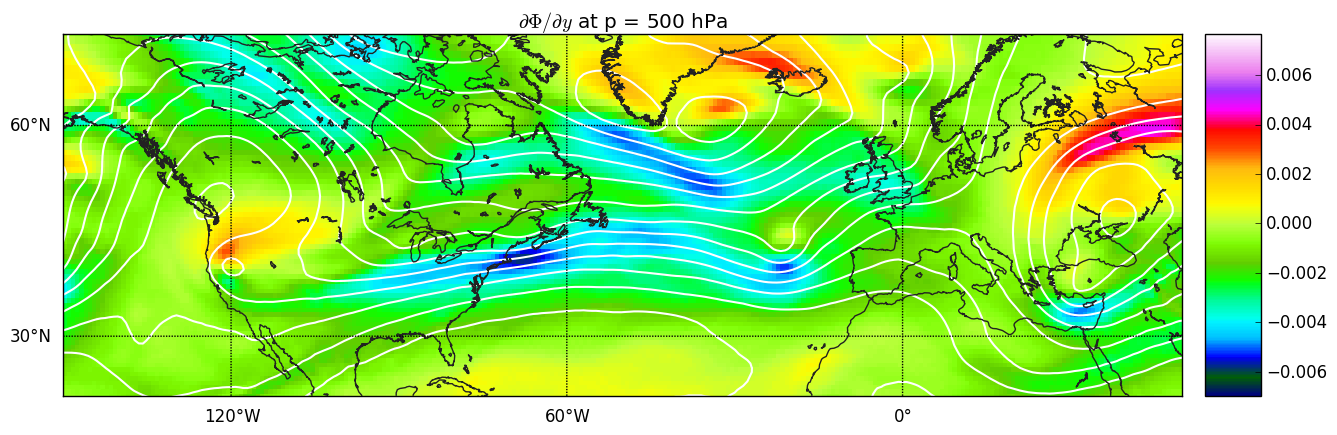

In [11]:
m.pcolormesh(lons, lats, dPhidy[n,:,:], cmap=pl.cm.gist_ncar)
m.colorbar()
m.contour(lons, lats, Phi[n,:,:], 15, colors='w', linewidths=1.5)
m.drawcoastlines(color='#222222')
# draw parallels.
parallels = np.arange(0.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('$\partial \Phi/\partial y$ at p = {0:.0f} hPa'.format(p[n]/100));
pl.tight_layout()

___
In a similar fashion, it is possible to compute vertical gradients. Note that your data is in pressure coordinates. Vertical gradients will therefore expressed in a change per unit of Pascal. In the example below, we calculate the vertical gradient of temperature

$$ \dfrac{\partial T}{\partial p} \approx \dfrac{\delta T}{\delta p} = \dfrac{\dfrac{\delta T}{\delta k}}{\dfrac{\delta p}{\delta k}}.$$

We plot the data again at the previously chosen height. Our pressure levels are only a one-dimensional array, but `numpy` provides a trick to make the array pretend to be three-dimensional like the temperature array. With the `newaxis` keyword, we can add an additional axis that takes automatically the correct values.

In [12]:
dTdp = np.gradient(T[:,:,:], axis=0) / np.gradient(p[:, np.newaxis, np.newaxis], axis=0)

/usr/local/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


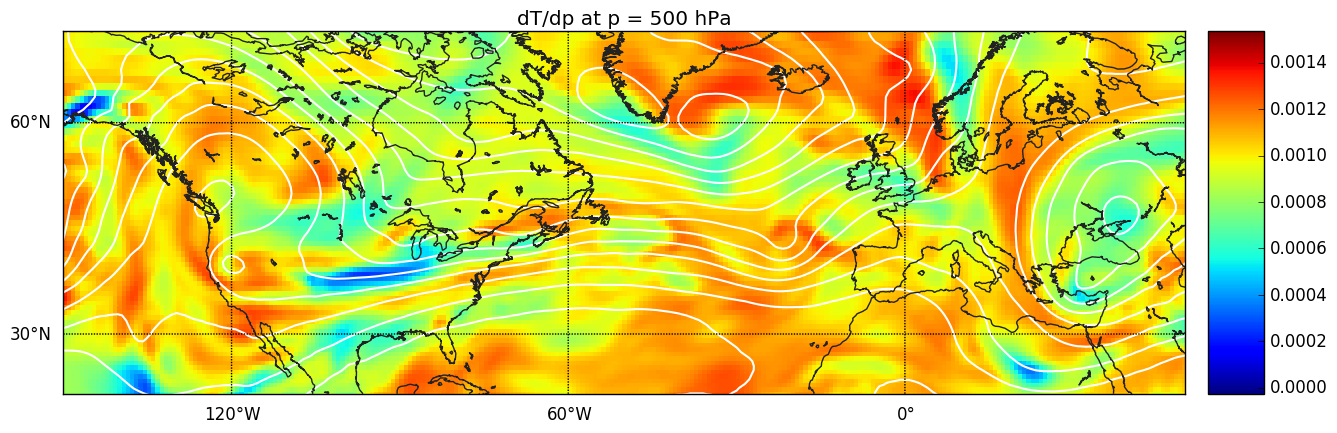

In [13]:
m.pcolormesh(lons, lats, dTdp[n,:,:], cmap=pl.cm.jet)
m.colorbar()
m.contour(lons, lats, Phi[n,:,:], 15, colors='w', linewidths=1.5)
m.drawcoastlines(color='#222222')
# draw parallels.
parallels = np.arange(0.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('dT/dp at p = {0:.0f} hPa'.format(p[n]/100.));
pl.tight_layout()

___
### Exercises
You have reached the end of the examples. Now it is time for you to develop your own skills. Below you find exercises that will help you to develop the skills you need in the coming weeks.
___
#### Exercise 1
1. Plot the temperature at 850 hPa and at 300 hPa.
2. Calculate and plot the temperature difference between 850 and 300 hPa.
3. Plot the temperature at 850 hPa and 300 hPa at a latitude of 45 degrees in an xy-plot that has longitude on the horizontal axis and temperature on the vertical.
___
#### Exercise 2
1. Calculate and plot the zonal gradient in geopotential height at 500 hPa.
2. Calculate and plot the meridional gradient in geopotential height at 500 hPa.
3. Calculate and plot the magnitude of the horizontal gradient vector.
$\nabla_h \Phi \equiv \left(\dfrac{\partial \Phi}{\partial x}, \dfrac{\partial \Phi}{\partial y}, 0 \right)$
___
#### Exercise 3
1. Calculate the 3D field of potential temperature $\theta \equiv T \left( \dfrac{p_0}{p} \right)^{R_d/c_p}$
2. Calculate and plot the vertical cross section of zonal mean potential temperature.
3. Calculate the zonal mean zonal wind and add it to the previous plot. Do you see a jetstream?
___
#### Exercise 4
1. Calculate all terms of the conservation of mass equation in pressure coordinates $\dfrac{\partial u}{\partial x} + \dfrac{\partial v}{\partial y} + \dfrac{\partial \omega}{\partial p}$ and check whether they add to zero.
2. Calculate the horizontal divergence at 300 hPa.
___
#### Exercise 5
1. Calculate (only in math, either on paper or in the notebook using $\LaTeX$) the cross product of the nabla operator and the wind vector $\omega = \nabla \times \boldsymbol{U}$ and explain the meaning of $\omega$.
2. Calculate (only in math, either on paper or in the notebook using $\LaTeX$) $\zeta = \boldsymbol{k} \cdot \left( \nabla \times \boldsymbol{U} \right)$ and explain the meaning of $\zeta$.
3. Calculate and plot $\zeta$ at the 500 hPa level.

#### Exercise 6 (bonus)
1. Calculate the derivative in the meridional direction of the geopotential $\dfrac{\partial \Phi}{\partial y}$ without using a loop.

___
Work out the exercises below here.
___